<a href="https://colab.research.google.com/github/min02yam/Data-study/blob/main/20220508_iris_%ED%95%98%EB%8A%94%EC%A4%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Data analysis & Evaluation


## 3-1. iris 데이터셋에서 Species rpart, svm예측 모형을 만든 후 높은 Accuracy값을 가지는 모델의 예측값을 csv 파일로 제출하시오.

## 3-2. 그 모델의 ROC곡선을 그리고, AUC값도 구하시오.

> SVM 정리: [링크 텍스트](https://) 
  - e1071:: svm, tune.svm  #SVM
  - kernlab:: ksvm, #SVM 피처 선택
  - (+ caret:: rfeControl #교차 검증)


> 디시전트리 정리: [링크 텍스트](https://)

> - predict에러 https://stackoverflow.com/questions/23085096/type-parameter-of-the-predict-function
> -~roc에러 
Error: ‘list’ object cannot be coerced to type ‘double’
https://finnstats.com/index.php/2022/02/01/error-list-object-cannot-be-coerced-to-type-double/
멀티클래스에 뉴메릭 못씀
~~as.numeric(unlist(List))~~

> multi-label 분류 성능지표
- balanced ➡️ Accuracy
- imbalanced ➡️ f1-score


In [132]:
install.packages(c("e1071","kernlab","caret"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages(c("e1071", "kernlab", "caret")):
“installation of package ‘e1071’ had non-zero exit status”


In [133]:
library(e1071); library(kernlab); library(caret)

In [134]:
#rm(list=ls())
str(iris)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


In [135]:
#시드설정 및 데이터 분할
set.seed(2022)
inx<-sample(1:nrow(iris), nrow(iris)*0.7, replace=FALSE)
train<-iris[inx,]
test<-iris[-inx,]

### STEP1. e1071 패키지이용 모델링

In [136]:
#e1071
esvm<-tune.svm(Species~., data=train, gamma=10^(-6:-1), cost=10^(-2:2))$best.model 

-  `HMH기울기(gamma)` 0.01 
- `비용값(cost)` 10
- `best performance` 0.01~대로 계속 나옴.

In [137]:
#summary( tune.svm(Species~., data=train, gamma=2^(-2:1), cost=2^(2:4)) )  # best performance: 0.02 

### STEP2. kernlab+caret 패키지 이용 모델링

In [138]:
ksvm(Species~., data= train, kernel="rbfdot") # 디폴트 가우시안 래디컬 0.009524 
# ksvm(Species~., data= train, kernel="vanilladot") # 성능비슷함

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Gaussian Radial Basis kernel function. 
 Hyperparameter : sigma =  0.917538361866533 

Number of Support Vectors : 50 

Objective Function Value : -4.553 -5.078 -14.5891 
Training error : 0.009524 

In [139]:
c(10^(-1:1),5)

[1]  0.1  1.0 10.0  5.0

In [140]:
cost<-c(10^(-1:1),5)

acc<-sapply(cost, function(x){ 
  set.seed(2022)
fit<-ksvm(Species~. , train, kernel="rbfdot", C=x)    
  pred<-predict(fit, test)
  agr<-ifelse(pred==test[,5], 1, 0)
  acc<-sum(agr)/nrow(test)
  
  return(acc)
})

In [141]:
install.packages("ROCR"); library(ROCR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



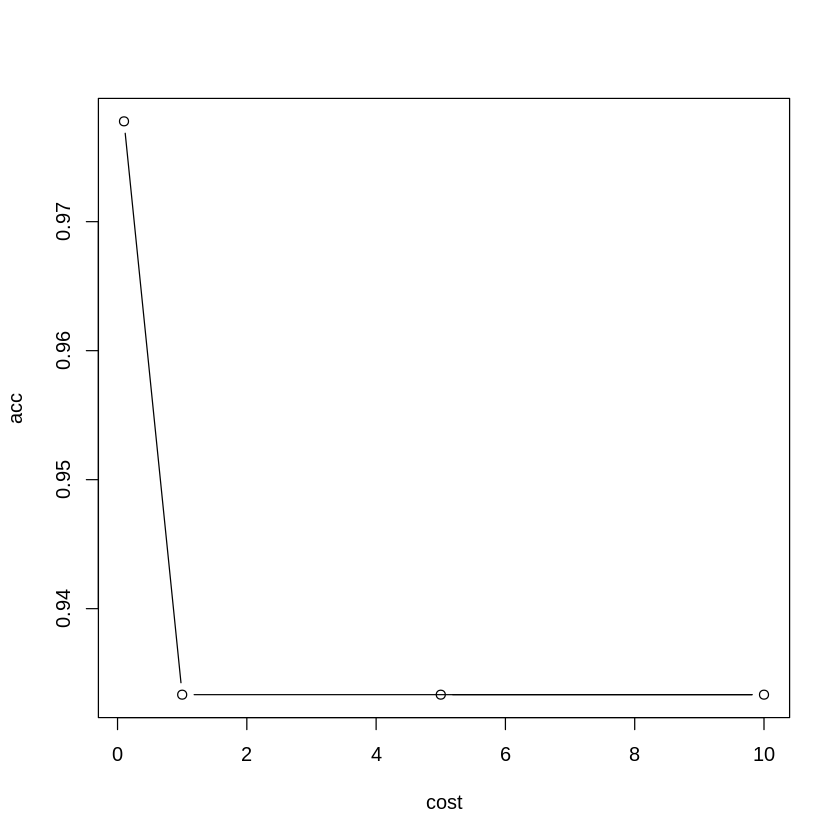

In [142]:
plot(cost, acc, type="b")

- 코스트 범위 다시 줘보기

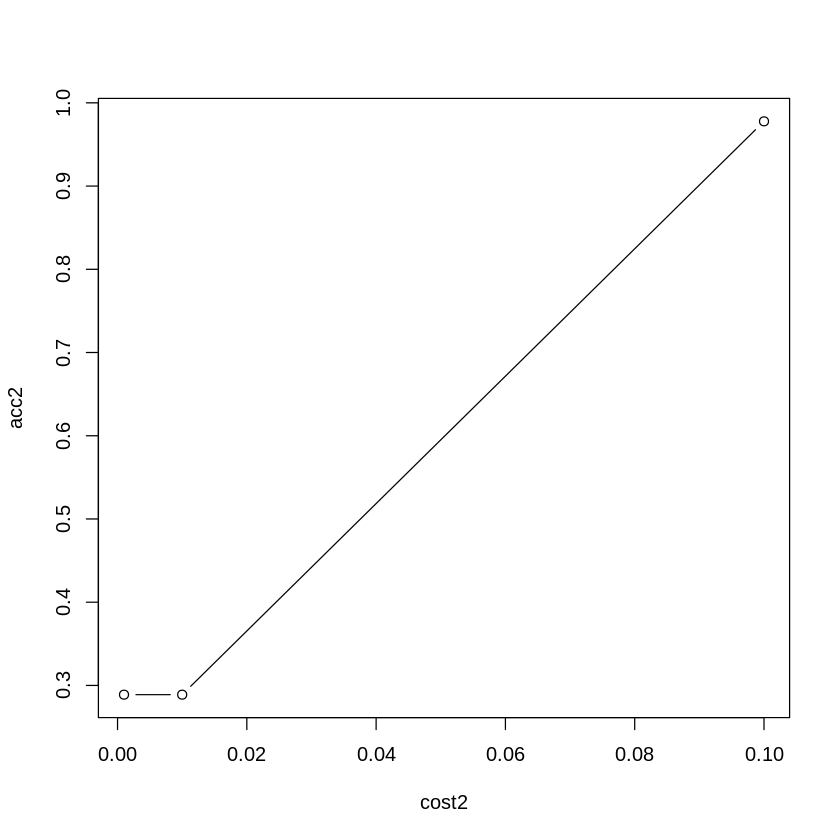

In [143]:
cost2<-c(10^(-3:-1))

acc2<-sapply(cost2, function(x){ 
  set.seed(2022)
fit<-ksvm(Species~. , train, kernel="rbfdot", C=x)    
  pred<-predict(fit, test)
  agr<-ifelse(pred==test[,5], 1, 0)
  acc2<-sum(agr)/nrow(test)
  
  return(acc2)
})

plot(cost2, acc2, type="b")

- `비용값(cost)` 0.1이 제일 좋고, 앞서 시행했던 기본파라미터 C=1은 성능 비교적 별로임

In [144]:
ksvm<-ksvm(Species~., data= train, kernel="rbfdot", C=0.1 ) #파라미터 수정

### STEP3. 최종모형 도출 및 성능 평가

In [145]:
pred_esvm<-predict(esvm, test) 
pred_ksvm<-predict(ksvm, test)
confusionMatrix(pred_esvm, test[,5], positive = "1") #  Accuracy : 0.9333  
confusionMatrix(pred_ksvm, test[,5], positive = "1") # Accuracy : 0.9778 

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         15          0         0
  versicolor      0         10         0
  virginica       0          3        17

Overall Statistics
                                         
               Accuracy : 0.9333         
                 95% CI : (0.8173, 0.986)
    No Information Rate : 0.3778         
    P-Value [Acc > NIR] : 6.255e-15      
                                         
                  Kappa : 0.8985         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.7692           1.0000
Specificity                 1.0000            1.0000           0.8929
Pos Pred Value              1.0000            1.0000           0.8500
Neg Pred Value              1.0000            0.9143           1.0000
Prevalence

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         15          0         0
  versicolor      0         12         0
  virginica       0          1        17

Overall Statistics
                                          
               Accuracy : 0.9778          
                 95% CI : (0.8823, 0.9994)
    No Information Rate : 0.3778          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9664          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.9231           1.0000
Specificity                 1.0000            1.0000           0.9643
Pos Pred Value              1.0000            1.0000           0.9444
Neg Pred Value              1.0000            0.9697           1.0000
P

In [146]:
library(pROC)
#class(pred_esvm) ; #class(test[,5])
#roc_esvm<-roc(  as.numeric(pred_esvm), as.numeric(test[,5])    )
?roc

In [155]:
roc_esvm <- multiclass.roc( as.numeric(pred_esvm) , as.numeric(test[,5]) ) ; auc(roc_esvm) # 0.975
roc_ksvm <- multiclass.roc( as.numeric(pred_ksvm) , as.numeric(test[,5]) ) ; auc(roc_ksvm) # 0.991

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Multi-class area under the curve: 0.975

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Multi-class area under the curve: 0.9907